<a href="https://colab.research.google.com/github/flohmannjr/TCC530/blob/main/TCC530_Modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TCC530 - Modelos

## Importações de bibliotecas

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os, random

import tensorflow as tf

from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Embedding, TextVectorization
from tensorflow.keras.layers import Dense, Dropout, GlobalMaxPool1D, Input
from tensorflow.keras.layers import Bidirectional, Conv1D, GRU, LSTM

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

## Configurações

In [2]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100

sns.set_style("darkgrid")

### Constantes

In [3]:
SEMENTE = 2008193

LIMITE_DICIONARIO = 80000

MAXIMO_MODELOS = 20

ENTRADA_FORMATO = (1,)
ENTRADA_TIPO = tf.string

ATIVACAO_CNN = 'relu'
ATIVACAO_RNN = 'tanh'
ATIVACAO_SAIDA = 'sigmoid'

FILTROS = 32
NUCLEO_TAMANHO = 64
PREENCHIMENTO = 'same'

NEURONIOS_DENSO = 128
ABANDONOS = 0.1

PERDA = 'binary_crossentropy'
APRENDIZADO = 0.001
METRICAS = ['accuracy']

ITERACOES = 5

## Dados

Fake.Br Corpus https://github.com/roneysco/Fake.br-Corpus

In [4]:
dados = pd.read_csv('https://raw.githubusercontent.com/roneysco/Fake.br-Corpus/master/preprocessed/pre-processed.csv',
                    index_col=['index'])

In [5]:
dados['label'].replace({'fake': 0, 'true': 1}, inplace=True)

In [6]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7200 entries, 0 to 7199
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   label              7200 non-null   int64 
 1   preprocessed_news  7200 non-null   object
dtypes: int64(1), object(1)
memory usage: 168.8+ KB


In [7]:
dados

,label,preprocessed_news
index,,
0,0,katia abreu diz vai colocar expulsao moldura n...
1,0,ray peita bolsonaro conservador fake entrevist...
2,0,reinaldo azevedo desmascarado policia federal ...
3,0,relatorio assustador bndes mostra dinheiro pub...
4,0,radialista americano fala sobre pt vendem ilus...
...,...,...
7195,1,jornal britanico acao contra lula lava jato se...
7196,1,temer diz acionou pf cade investigar aumentos ...
7197,1,obstaculos politicos temer especialistas ouvid...


In [8]:
dados['label'].value_counts()

0    3600
1    3600
Name: label, dtype: int64

In [9]:
X = dados['preprocessed_news']
y = dados['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEMENTE)

In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5760,), (1440,), (5760,), (1440,))

In [11]:
X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype

(dtype('O'), dtype('O'), dtype('int64'), dtype('int64'))

### Converter texto em números

In [12]:
# media_palavras_por_texto = round(sum([len(texto.split()) for texto in X_train]) / len(X_train))
maximo_palavras_por_texto = max([len(texto.split()) for texto in X_train])

# tamanho_texto = media_palavras_por_texto
tamanho_texto = maximo_palavras_por_texto

#### Vetorização (Vectorization)

In [13]:
vetorizador = TextVectorization(max_tokens=LIMITE_DICIONARIO,               # (Default: None) Máximo de tokens (palavras) no dicionário.
                                standardize='lower_and_strip_punctuation',  # (Default) Texto em caixa baixa e retira caracteres especiais.
                                split='whitespace',                         # (Default) Separador de tokens.
                                ngrams=None,                                # (Default) Tokens por grupo. (None = não agrupar tokens.)
                                output_mode='int',                          # (Default) Como mapear tokens para números.
                                output_sequence_length=tamanho_texto)       # (Default: None) Tamanho do texto, completado ou truncado, se necessário. (Válido apenas para 'int'.)

In [14]:
vetorizador.adapt(X_train)

In [15]:
texto = random.choice(X_train)
print(texto)

vetorizador([texto])

aliados pt dizem dilma votos suficientes senado retomar poder coluna esplanada jornalista leandro mazzini informou lula diz votos suficientes barrar impeachment dilma senado acordo publicacao deixou brasilia fim semana acompanhado senador roberto requiao apos jantar senadores aliados jantar fracasso poucos senadores compareceram sobrou marmitex lula insiste dizer apoio suficiente dilma volte assumir poder fundo lixando dilma quer carginho foro livrar justica primeira instancia assim ocorreu votacao impeachment camara deputados petista pode estar blefando novamente mentindo sobre numeros alias mentir sobre numeros especialidade lula lado oposto senado calcula presidente interino michel temer votos manter dilma afastada planalto


<tf.Tensor: shape=(1, 4229), dtype=int64, numpy=array([[903,  73, 637, ...,   0,   0,   0]])>

In [16]:
vocabulario = vetorizador.get_vocabulary()

In [17]:
# [UNK] = Desconhecido, fora do limite do dicionário.
len(vocabulario), vocabulario[:5], vocabulario[-5:]

(73258,
 ['', '[UNK]', 'nao', 'lula', 'ser'],
 ['aapesar', 'aachen', 'aace', 'aabertura', 'aabb'])

#### Incorporação (Embedding)

In [18]:
incorporador = Embedding(input_dim=LIMITE_DICIONARIO,  # Tamanho do vocabulário de entrada.
                         output_dim=128,               # Dimensão do vetor de saída. (Geralmente um múltiplo de 8.)
                         input_length=tamanho_texto)   # Tamanho do texto de entrada.

In [19]:
texto = random.choice(X_train)
print(texto)

incorporador(vetorizador([texto]))

luiz fux decisao alerj soltar deputados promiscua vulgar certamente sera revista stf entrevista exclusiva bbc brasil ministro tambem defendeu candidatura joaquim barbosa presidencia perguntado sobre lula reiterou candidato condenacao segundo grau nao deve concorrer lamentavel vulgar promiscua assim ministro supremo tribunal federal luiz fux classifica decisao assembleia legislativa rio janeiro soltar deputados estaduais pmdb jorge picciani presidente alerj paulo melo edson albertassi suspeitos formar organizacao criminosa desviar recursos publicos presos determinacao tribunal regional federal regiao prisao revogada sexta decisao maioria deputados estaduais rj entrevista exclusiva bbc brasil fux destaca alerj nao poderia ter decidido sobre prisoes ter consultado judiciario afirmou categoricamente soltura deputados estaduais assembleias certamente sera revista supremo alem rio janeiro assembleias rio grande norte mato grosso usaram decisao stf dar senado palavra final sobre suspensao man

<tf.Tensor: shape=(1, 4229, 128), dtype=float32, numpy=
array([[[-0.03684732,  0.04135654, -0.00758588, ..., -0.00584275,
         -0.00530457,  0.03908917],
        [ 0.04011988, -0.04461941,  0.00848202, ..., -0.01348932,
          0.01206582,  0.02791141],
        [-0.00603864, -0.01655811,  0.02500397, ..., -0.00442842,
         -0.01402735, -0.03863328],
        ...,
        [ 0.02284677,  0.03437961,  0.00976177, ..., -0.00103981,
          0.04044895, -0.02518202],
        [ 0.02284677,  0.03437961,  0.00976177, ..., -0.00103981,
          0.04044895, -0.02518202],
        [ 0.02284677,  0.03437961,  0.00976177, ..., -0.00103981,
          0.04044895, -0.02518202]]], dtype=float32)>

## Funções

In [20]:
def grafico_historico_por_iteracao(historico):

    for chave in historico.history.keys():
        sns.lineplot(data=historico.history[chave], label=chave)

    plt.title('Histórico por iteração')
    plt.xlabel('Iteração')
    plt.ylabel('')

    plt.legend(frameon=True, facecolor='white')
    plt.show()

def avaliar_modelo(validacao, previsao, rotulos=None, cmap='summer_r'):
    print(classification_report(validacao, previsao, target_names=rotulos))

    ConfusionMatrixDisplay.from_predictions(validacao, previsao, display_labels=rotulos, xticks_rotation='vertical', cmap=cmap)
    plt.grid(False)

    relatorio = classification_report(validacao, previsao, target_names=rotulos, output_dict=True)

    return {'acuracia': relatorio['accuracy'],
            'precisao': relatorio['weighted avg']['precision'],
            'revocacao': relatorio['weighted avg']['recall'],
            'pontuacao-f1': relatorio['weighted avg']['f1-score']}

def dados_modelo(indice):
    avaliacoes[indice] = modelos[indice].evaluate(X_test, y_test)
    probabilidades[indice] = modelos[indice].predict(X_test)
    previsoes[indice] = tf.squeeze(tf.round(probabilidades[indice]))
    relatorios[indice] = avaliar_modelo(y_test, previsoes[indice])

## Modelos

In [21]:
modelos = [None] * MAXIMO_MODELOS

avaliacoes     = [None] * MAXIMO_MODELOS
probabilidades = [None] * MAXIMO_MODELOS
previsoes      = [None] * MAXIMO_MODELOS
relatorios     = [None] * MAXIMO_MODELOS

historicos = [None] * MAXIMO_MODELOS

modelo_numero = 0

### Modelo 0: Naive Bayes com codificador TF-IDF (baseline)

In [22]:
modelo_nome = f'modelo_{modelo_numero}_naive_bayes'

modelos[modelo_numero] = Pipeline([('tdidf', TfidfVectorizer()),
                                   ('clf', MultinomialNB())]) # clf = classifier

modelos[modelo_numero].fit(X_train, y_train)

Pipeline(steps=[('tdidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [23]:
previsoes[modelo_numero] = modelos[modelo_numero].predict(X_test)

              precision    recall  f1-score   support

           0       0.99      0.22      0.36       741
           1       0.55      1.00      0.71       699

    accuracy                           0.60      1440
   macro avg       0.77      0.61      0.53      1440
weighted avg       0.77      0.60      0.53      1440



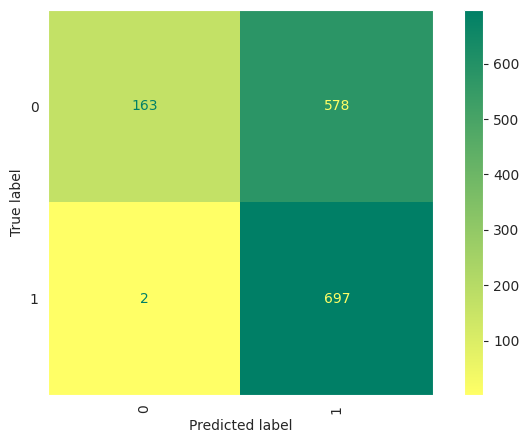

In [24]:
relatorios[modelo_numero] = avaliar_modelo(y_test, previsoes[modelo_numero])

In [25]:
relatorios[modelo_numero]

{'acuracia': 0.5972222222222222,
 'precisao': 0.7737070707070706,
 'revocacao': 0.5972222222222222,
 'pontuacao-f1': 0.5279508332382786}

### Modelo 1: Denso

In [28]:
modelo_numero += 1

modelo_nome = f'modelo_{modelo_numero}_denso'

entradas = Input(shape=ENTRADA_FORMATO, dtype=ENTRADA_TIPO, name='camada_entrada')

camadas = vetorizador(entradas)
camadas = incorporador(camadas)
camadas = GlobalMaxPool1D(name='agrupamento_maximo_global')(camadas)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=Adam(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[1].fit(x=X_train,
                                           y=y_train,
                                           batch_size=NUCLEO_TAMANHO,
                                           epochs=ITERACOES,
                                           validation_data=(X_test, y_test),
                                           verbose=1)

Epoch 1/5
90/90 [==============================] - 25s 256ms/step - loss: 0.5991 - accuracy: 0.6276 - val_loss: 0.5229 - val_accuracy: 0.8542
Epoch 2/5
90/90 [==============================] - 20s 226ms/step - loss: 0.4246 - accuracy: 0.9391 - val_loss: 0.3705 - val_accuracy: 0.9521
Epoch 3/5
90/90 [==============================] - 20s 218ms/step - loss: 0.2881 - accuracy: 0.9602 - val_loss: 0.2648 - val_accuracy: 0.9549
Epoch 4/5
90/90 [==============================] - 25s 280ms/step - loss: 0.2007 - accuracy: 0.9661 - val_loss: 0.2038 - val_accuracy: 0.9556
Epoch 5/5
90/90 [==============================] - 27s 297ms/step - loss: 0.1499 - accuracy: 0.9693 - val_loss: 0.1704 - val_accuracy: 0.9597


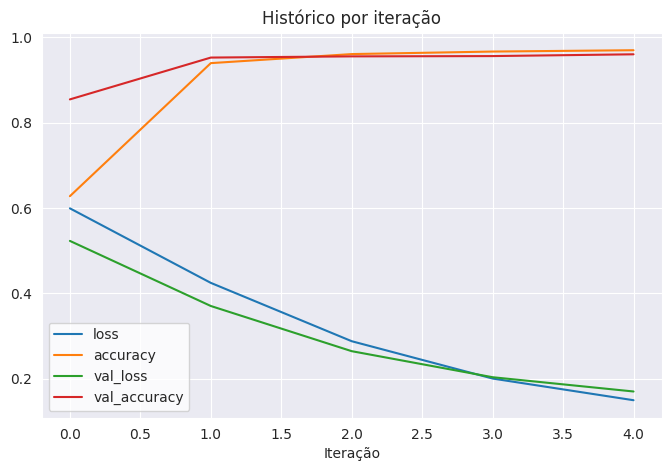

In [29]:
grafico_historico_por_iteracao(historicos[modelo_numero])

45/45 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       741
           1       0.96      0.95      0.96       699

    accuracy                           0.96      1440
   macro avg       0.96      0.96      0.96      1440
weighted avg       0.96      0.96      0.96      1440



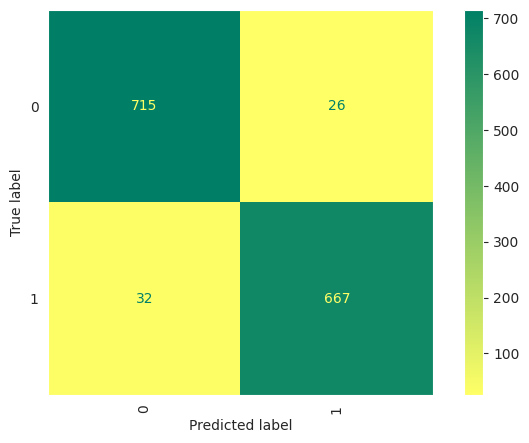

In [30]:
dados_modelo(modelo_numero)

In [31]:
relatorios[modelo_numero]

{'acuracia': 0.9597222222222223,
 'precisao': 0.9597443888106539,
 'revocacao': 0.9597222222222223,
 'pontuacao-f1': 0.9597166218637992}

## Comparar modelos

In [34]:
comparacao = pd.DataFrame([r for r in relatorios if r is not None])
comparacao = comparacao.reset_index().melt(id_vars='index').rename(columns=str.title)

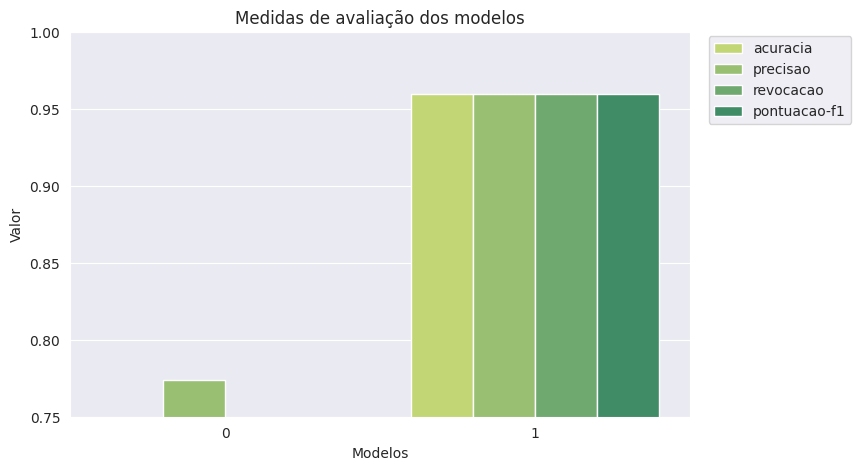

In [36]:
sns.barplot(data=comparacao, x='Index', y='Value', hue='Variable', palette='summer_r')

plt.ylim(0.75, 1.0)

plt.title('Medidas de avaliação dos modelos')
plt.xlabel('Modelos')
plt.ylabel('Valor')

plt.legend(loc=(1.03, 0.76));